In [13]:
import math
import json
import pickle
import random
from gensim import models
from gensim import matutils
import logging
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time
from nltk.tokenize import sent_tokenize
import glob
import argparse
import os


In [14]:
### Drap the review whcih has same business id in business object with 'Restaurants' categories.
business_id = []
business_output = []
with open("yelp_academic_dataset.json", 'r') as f:
    for line in f.readlines():
        business_json = json.loads(line)
        if 'categories' in business_json:
            business_output.append(line)
            if 'Restaurants' in business_json['categories']:
                business_id.append(business_json['business_id'])
print "Business Finished"

Business Finished


In [15]:
review_output = []
with open("yelp_academic_dataset.json", 'r') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        if 'text' in review_json:
            if review_json['business_id'] in business_id:
                review_output.append(line)
with open ( "yelp_academic_dataset_review.json", 'w' ) as f:
    f.write(''.join(review_output))
print "Review Finished"

Review Finished


In [16]:
path2buisness="yelp_academic_dataset_business.json"
path2reviews="yelp_academic_dataset_review.json"

categories = set([])
restaurant_ids = set([])
cat2rid = {}
rest2rate={}
rest2revID = {}
r = 'Restaurants'
with open (path2buisness, 'r') as f:
    for line in f.readlines():
        business_json = json.loads(line)
        bjc = business_json['categories']
        #cities.add(business_json['city'])
        if r in bjc:
            if len(bjc) > 1:
                #print(bjc)
                restaurant_ids.add(business_json['business_id'])
                categories = set(bjc).union(categories) - set([r])
                stars = business_json['stars']
                rest2rate[ business_json['business_id'] ] = stars
                for cat in bjc:
                    if cat == r:
                        continue
                    if cat in cat2rid:
                        cat2rid[cat].append(business_json['business_id'])
                    else:
                        cat2rid[cat] = [business_json['business_id']]

print "saving restaurant ratings"
with open ( 'restaurantIds2ratings.txt', 'w') as f:
    for key in rest2rate:
        f.write( key + " " + str(rest2rate[key]) + "\n")
    #clearing from memory
rest2rate=None
with open('data_cat2rid.pickle', 'wb') as f:
    pickle.dump(cat2rid,f)

with open (path2reviews, 'r') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        if review_json['business_id'] in restaurant_ids:
            if review_json['business_id'] in rest2revID:
                rest2revID[ review_json['business_id'] ].append(review_json['review_id'])
            else:
                rest2revID[ review_json['business_id'] ] = [ review_json['review_id'] ]

with open('data_rest2revID.pickle', 'wb') as f:
    pickle.dump(rest2revID,f)

nz_count = 0
valid_cats = []
for i, cat in enumerate(cat2rid):
    cat_total_reviews = 0
    for rid in cat2rid[cat]:
        #number of reviews for each of restaurants
        if rid in rest2revID:
            cat_total_reviews = cat_total_reviews + len(rest2revID[rid])

    if cat_total_reviews > 30:
        nz_count = nz_count + 1
        valid_cats.append(cat)
        #print( cat, cat_total_reviews)


print "finish process"

saving restaurant ratings
finish process


In [17]:
sample_size = 10 #len(valid_cats) # This specifies how many cuisines you would like to save
                                  # if this process takes too long you can change it to something smaller like 5, 6 ...
    
#print nz_count, ' non-zero number of reviews in categories out of', len(cat2rid), 'categories')
#x = range(nz_count)
###def sample_categories(sample_sizes = 10):
print "sampling categories"
sample_rid2cat={}

cat_sample = random.sample(valid_cats, sample_size)
for cat in cat_sample:
    for rid in cat2rid[cat]:
        if rid in rest2revID:
            if rid not in sample_rid2cat:
                sample_rid2cat[rid] = []
            sample_rid2cat[rid].append(cat)
#remove from memory
rest2revID=None
#    print (len(sample_rid2cat), len(cat2rid), len(valid_cats), len(cat_sample))
    
print "reading from reviews file..."
#ensure categories is a directory
sample_cat2reviews={}
sample_cat2ratings={}
num_reviews = 0
with open (path2reviews, 'r') as f:
    for line in f.readlines():
        review_json = json.loads(line)
        rid = review_json['business_id']
        if rid in sample_rid2cat:
            for rcat in sample_rid2cat [ rid ]:
                num_reviews = num_reviews + 1
                if rcat in sample_cat2reviews:
                    sample_cat2reviews [ rcat ].append(review_json['text'])
                    sample_cat2ratings [ rcat ].append( str(review_json['stars']) )
                else:
                    sample_cat2reviews [ rcat ] = [review_json['text']]
                    sample_cat2ratings [ rcat ] = [ str(review_json['stars']) ]

print "finish reading reviews"

sampling categories
reading from reviews file...
finish reading reviews


In [18]:
print "saving categories"
#save categories
for cat in sample_cat2reviews:
    print cat
    with open ('categories/' + cat.replace('/', '-').replace(" ", "_") + ".txt" , 'w') as f:
        f.write(u'\n'.join(sample_cat2reviews[cat]).encode('utf-8').strip())

print "finish saving"

saving categories
Portuguese
Mexican
Salad
Greek
Delis
Wine Bars
Thai
Persian/Iranian
Venues & Event Spaces
Belgian
finish saving


In [19]:
#save sample for restaurant reviews
print "sampling restaurant reviews"
def sample_reviews(rate_sizes = 100000):
    sample_size = min(rate_sizes, num_reviews)
    rev_sample = random.sample(range(num_reviews), sample_size)
    my_sample_v2 = []
    sample_ratings = []
    sorted_rev_sample = sorted(rev_sample)
    count = 0
    max_bound = 0
    for cat in sample_cat2reviews:
        new_max_bound = max_bound + len(sample_cat2reviews[cat])
        while count < sample_size and sorted_rev_sample[count] < new_max_bound:
            my_sample_v2.append( sample_cat2reviews[cat][ sorted_rev_sample[count] - max_bound ].replace("\n", " ").strip() )
            sample_ratings.append( sample_cat2ratings[cat][ sorted_rev_sample[count] - max_bound ] )
            count = count + 1
        max_bound = new_max_bound
        #if count in rev_sample:
        #    my_sample.append(rev.replace("\n", " ").strip())
        #count = count + 1

    with open ("review_sample_" + str(rate_sizes) + ".txt", 'w') as f:
        f.write('\n'.join(my_sample_v2).encode('ascii','ignore') )

    with open ("review_ratings_" + str(rate_sizes) + ".txt", 'w') as f:
        f.write('\n'.join(sample_ratings).encode('ascii','ignore') )
        
sample_reviews()

sampling restaurant reviews


In [20]:
def sim_matrix():
    logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
    K_clusters = 10
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000,
                                     min_df=2, stop_words='english',
                                     use_idf=True)

    
    
    if not os.path.isdir("categories"):
        print "you need to generate the cuisines files 'categories' folder first"
        return
    
    text = []
    c_names = []
    cat_list = glob.glob ("categories/*")
    cat_size = len(cat_list)
    if cat_size < 1:
        print "you need to generate the cuisines files 'categories' folder first"
        return
    
    sample_size = min(30, cat_size)
    cat_sample = sorted( random.sample(range(cat_size), sample_size) )
    #print (cat_sample)
    count = 0
    for i, item in enumerate(cat_list):
        if i == cat_sample[count]:
            li =  item.split('/')
            cuisine_name = li[-1]
            c_names.append(cuisine_name[:-4].replace("_"," "))
            with open ( item ) as f:
                text.append(f.read().replace("\n", " "))
            count = count + 1
        
        if count >= len(cat_sample):
            print "generating cuisine matrix with:", count, "cuisines"
            break

    t0 = time()
    print("Extracting features from the training dataset using a sparse vectorizer")
    X = vectorizer.fit_transform(text)
    print("done in %fs" % (time() - t0))
    print("n_samples: %d, n_features: %d" % X.shape)

    corpus = matutils.Sparse2Corpus(X,  documents_columns=False)
    lda = models.ldamodel.LdaModel(corpus, num_topics=100)

    doc_topics = lda.get_document_topics(corpus)
    cuisine_matrix = [] #similarity of topics
    # computing cosine similarity matrix
    for i, doc_a in enumerate(doc_topics):
        #print (i)
        sim_vecs = []
        for j , doc_b in enumerate(doc_topics):
            w_sum = 0
            if ( i <= j ):
                norm_a = 0
                norm_b = 0
                
                for (my_topic_b, weight_b) in doc_b:
                    norm_b = norm_b + weight_b*weight_b

                for (my_topic_a, weight_a) in doc_a:
                    norm_a = norm_a + weight_a*weight_a
                    for (my_topic_b, weight_b) in doc_b:
                        if ( my_topic_a == my_topic_b ):
                            w_sum = w_sum + weight_a*weight_b

                norm_a = math.sqrt(norm_a)
                norm_b = math.sqrt(norm_b)
                denom = (float) (norm_a * norm_b)
                if denom < 0.0001:
                    w_sum = 0
                else:
                    w_sum = w_sum/(denom)
            else:
                w_sum = cuisine_matrix[j][i]
            sim_vecs.append(w_sum)

        cuisine_matrix.append(sim_vecs)

    with open( 'cuisine_sim_matrix.csv', 'w') as f:
        f.write(",".join(c_names)+"\n")
        for i_list in cuisine_matrix:
            s = ""
            my_max = max(i_list)
            for tt in i_list:
                s = s+str(tt/my_max) + " "
            s = s.strip()
            f.write(",".join(s.split())+"\n") #should the list be converted to m

    
    with open('cuisine_indices.txt', 'w') as f:
        f.write( "\n".join(c_names))
sim_matrix()

generating cuisine matrix with: 10 cuisines
Extracting features from the training dataset using a sparse vectorizer
done in 4.041000s


n_samples: 10, n_features: 10000


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


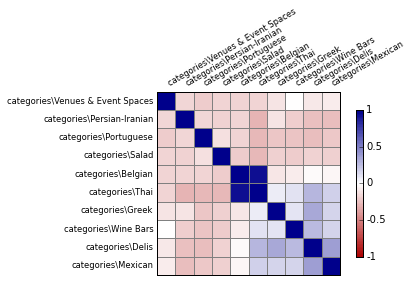

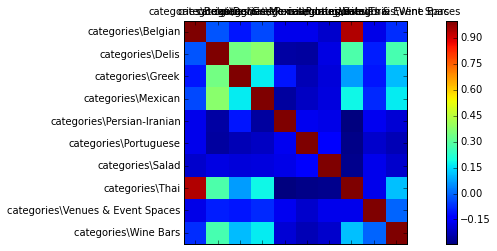

In [21]:
# plot similarity matrix for cuisine
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
import pandas as pd
from biokit.viz import corrplot

cus_names = []
ci = open("cuisine_indices.txt")
for i in ci.readlines():
    i = i.strip("\n")
    cus_names.append(i)

df = pd.read_csv("cuisine_sim_matrix.csv")

df = df.corr()

c = corrplot.Corrplot(df)
c.plot(method='color')

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df, interpolation='nearest')
fig.colorbar(cax)
plt.xticks( arange(10), cus_names )
plt.yticks( arange(10), cus_names)
ax.axis('image')
#ax.set_xticklabels(['']+cus_names)
#ax.set_yticklabels(['']+cus_names)


plt.show()

In [22]:
def IdeaModel(K, numfeatures, sample_file, num_display_words, outputfile):
    K_clusters = K
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=numfeatures,
                                     min_df=2, stop_words='english',
                                     use_idf=True)

    text = []
    with open (sample_file, 'r') as f:
        text = f.readlines()

    t0 = time()
    print("Extracting features from the training dataset using a sparse vectorizer")
    X = vectorizer.fit_transform(text)
    print("done in %fs" % (time() - t0))
    print("n_samples: %d, n_features: %d" % X.shape)
    
    # mapping from feature id to acutal word
    id2words ={}
    for i,word in enumerate(vectorizer.get_feature_names()):
        id2words[i] = word

    t0 = time()
    print("Applying topic modeling, using LDA")
    print(str(K_clusters) + " topics")
    corpus = matutils.Sparse2Corpus(X,  documents_columns=False)
    lda = models.ldamodel.LdaModel(corpus, num_topics=K_clusters, id2word=id2words)
    print("done in %fs" % (time() - t0))
        
    output_text = []
    for i, item in enumerate(lda.show_topics(num_topics=K_clusters, num_words=num_display_words, formatted=False)):
        output_text.append("Topic: " + str(i))
        no_, terms = item
        for term, weight in terms:
            output_text.append( term + ": " + str(weight) )

    print "writing topics to file:", outputfile
    with open ( outputfile, 'w' ) as f:
        f.write('\n'.join(output_text))
###default
IdeaModel(int(100), int(50000), "review_sample_100000.txt", int(15), "sample_topics.txt")

Extracting features from the training dataset using a sparse vectorizer
done in 4.273000s
n_samples: 36280, n_features: 24283
Applying topic modeling, using LDA
100 topics
done in 42.481000s
writing topics to file: sample_topics.txt


In [23]:
dish_name = []
def draw_dish(line):
    word_list = ["had","have"]
    lines = line.split(" ")
    for i in word_list:
        if i in lines:
            index = lines.index(i)+1
            if lines[index] == "a" or lines[index] == "an" or lines[index] == "the":
                num=1
                tem_re = []
                while((index+num) < len(lines)):
                    if "." in lines[index+num]:
                        sp_word = lines[index+num].split(".")
                        tem_re.append(sp_word[0])
                        dish_name.append(' '.join(tem_re))
                        break
                    if "," in lines[index+num]:
                        sp_word = lines[index+num].split(",")
                        tem_re.append(sp_word[0])
                        dish_name.append(' '.join(tem_re))
                        break
                    if lines[index+num] == "that" or lines[index+num] == "of" or lines[index+num]=="which" or lines[index+num] == "with" or lines[index+num] == "for":
                        dish_name.append(' '.join(tem_re))
                        break
                    if lines[index+num] == "and":
                        dish_name.append(' '.join(tem_re))
                        index = index+num
                        num = 0
                        tem_re=[]
                    else:
                        tem_re.append(lines[index+num])
                    if len(tem_re) > 2:
                        break
                    num += 1
dish_cat = []
file_list = glob.glob ("categories/*")
for file_name in file_list:
    text_name = (file_name.split(os.sep)[1]).split(".")[0]
    with open(file_name, "r") as f:
        for line in f.readlines():
            draw_dish(line)
    dish_name = list(set(dish_name))
    dish_cat.append((text_name, dish_name))
    dish_name =[]
    
with open("topic_result.txt", 'w' ) as f:
    for text_i, dish_j in dish_cat:
        f.write("Categories:"+text_i+'\n')
        f.write('\n'.join(dish_j))
        f.write('\n')
print "Process finished"

Process finished


In [25]:
dish_count = []
#dish_name = []
#with open("topic_result.txt", 'r' ) as f:
    #dish_name.append(f.readlines()))
cat_count = []
for text_name,dish_name in dish_cat:
    for dish in dish_name:
        count = 0
        with open("review_sample_100000.txt", 'r') as f:
            for line in f.readlines():
                if dish in line:
                    count += 1
            dish_count.append((dish, count))
    dish_count=sorted(dish_count,key=lambda t:t[1], reverse=True)
    cat_count.append((text_name, dish_count))
    dish_count = []
    
with open("count_result.txt", 'w' ) as f:
    for text_name, dish_count in cat_count:
        f.write("Categories:"+text_name+'\n')
        for i,j in dish_count:
            f.write(i + " " + str(j))
            f.write('\n')
print "Process finished"

Process finished
